# Разработка классификатора новостей

**Нужно:**
* выбрать какой-либо новостной ресурс, где к новостям привязаны категории или метки (например http://lenta.ru, http://fontanka.ru, http://gazeta.ru)
* загрузить новости по некоторому набору (5-10) категорий за пару лет
* обучить классификатор на эти новостях
* продемонстрировать его работу, разработав простеший web-интерфейс (вариант - telegram-бот), куда пользователь вводит текст новости и на выходе получает наиболее вероятную категорию. В качестве фреймворка проще всего взять [Flask](http://flask.pocoo.org) (см. примеры) .

In [1]:
import requests
from bs4 import BeautifulSoup

### Что рассматривается
Использовался сайт http://www.fontanka.ru/ и 15 категорий с 2014 года по 2015

In [7]:
url = 'http://www.fontanka.ru/'
news_categs = {'autop' : 'Авто', 
               'culturecity' : 'Афиша', 
               'business' : 'Бизнес', 
               'politic' : 'Власть', 
               'spb' : 'Город',
               'money' : 'Деньги',
               'zhkh' : 'ЖКХ',
               'family' : 'Личная жизнь',
               'realty' : 'Недвижимость',
               'incd' : 'Проишествия',
               'sport' : 'Спорт',
               'technology' : 'Тезнологии',
               'turizm' : 'Туризм',
               'finances' : 'Финансы',
               'stroy' : 'Строительство'}
# range returns range of length-1. list(range(1, 12)) == [1, 2, ... , 11]
days = range(1, 32)
mounths = range(1, 13)
years = range(2014, 2017)

### Выгрузка фонтанки
Был использован архив новостей фонтанки http://www.fontanka.ru/fontanka/arc/all.html<br>
Было выгружено 13594 страницы. При этом были пропущены страницы содержащие видео или сайты, вроде, http://fontanka.fi<br>
В итоге была получена numpy матрица размера (13594, 2)

Ниже описан метод для парсинга одной календарной страницы, например <br>
http://www.fontanka.ru/fontanka/2016/01/01/all.html <br>
Этот метод возвращает ссылки на страницы с новостями по определенной категории<br>
Он необходим для процесса выгрузки

In [66]:
import numpy as np
list_cat_text = []
for cat in news_categs.keys():
    for y in years:
        for m in mounths:
            for d in days:
                calendar_url = 'http://www.fontanka.ru/'+str(cat)+'/'+str(y)+'/'+str(m)+'/'+str(d)+'/news.html'
                r = requests.get(calendar_url)
                if r.status_code == 200:
                    calendar_page = BeautifulSoup(r.text, 'lxml')
                    links = get_links(calendar_page, cat)
                    for l in links:
                        news_page_get = requests.get(l)
                        
                        with open('log.txt', 'a') as f:
                            f.write(l + '\n')
                            f.write(str(news_page_get.status_code) + '\n')
                        try:
                            news_page = BeautifulSoup(news_page_get.text, 'lxml')
                            parags = [p for p in news_page.find('div', 'article_fulltext').find_all('p', recursive=False)]
                            text = ' '.join([t.get_text().strip() for t in parags])
                            list_cat_text.append((cat, text))
                        except Exception:
                            print('something is wrong with {lk}'.format(lk=l))
                            continue
mat = np.array(list_cat_text)
mat.shape

something is wrong with http://www.fontanka.ru/2015/11/16/139/
something is wrong with http://www.fontanka.ru/2015/10/13/121/
something is wrong with http://www.fontanka.ru/2015/10/14/146/
something is wrong with http://www.fontanka.ru/2015/10/13/051/
something is wrong with http://www.fontanka.ru/2015/10/21/078/
something is wrong with http://www.fontanka.ru/2015/11/18/032/
something is wrong with http://www.fontanka.ru/2015/10/29/086/
something is wrong with http://www.fontanka.ru/2015/10/13/064/


(13594, 2)

In [58]:
import re
reg_cat = re.compile('[\w]+')
reg_site = re.compile('http:')
def get_links(soup_page, category):
    main_page = 'http://www.fontanka.ru'
    """
    soup_page -- page, that came through BeautifulSoup. This page contains links to news
                 like this one http://www.fontanka.ru/business/2015/01/01/news.html
    category -- links to categories that are needed to be found (there are pages that contain different category, 
                even though we selected different one, look up the link above)
            
    returns list of links to certain category
    """
    links = []
    for item in soup_page.find_all('div', 'calendar-item'):
        cat_link = item.find('a', 'categorylink')['href']
        cat = reg_cat.search(cat_link).group(0)
        if category == cat:
            item_title = item.find('div', 'calendar-item-title')
            posib_link = item_title.find('a')['href']
            if not reg_site.search(posib_link):
                link = main_page + posib_link
                links.append(link)
    return links
get_links(soup, 'business')

['http://www.fontanka.ru/2015/01/01/029/',
 'http://www.fontanka.ru/2015/01/01/014/']

### Распределение новостей по категориям

In [68]:
from collections import Counter

In [71]:
count = Counter(mat[:, 0])
count

Counter({'autop': 446,
         'business': 1381,
         'culturecity': 8,
         'family': 26,
         'finances': 974,
         'incd': 5566,
         'money': 51,
         'politic': 2142,
         'realty': 68,
         'spb': 1294,
         'sport': 973,
         'stroy': 43,
         'technology': 238,
         'turizm': 149,
         'zhkh': 235})

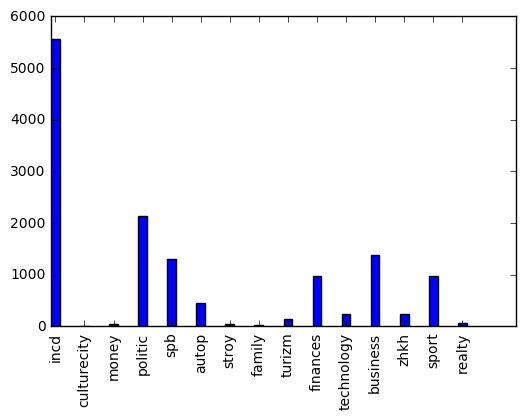

In [93]:
import matplotlib.pyplot as plt
inds = range(len(count.keys()))
plt.bar(inds, count.values(), width=0.3)
x_labels = [news_categs[l] for l in count.keys()]
plt.xticks(np.array(inds) + 0.3/2., count.keys(), rotation='vertical')
plt.show()

Распределние новостей очень неравномерное, поэтому при построении svm модели будет использована опция<br> `class_weight='balanced`

### Построение модели

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

Используется отдельный метод для построения tf_idf vectorizer, чтобы получить стемы слов. В результате должен получиться меньше словарь, что полезно, с учётом количества рассматриваемых документов. <br>
Остальные опции можно было использовать и без создания отдельного метода:
- max_df=0.8 отсев по максимальной частоте слова в документах
- min_df= 5 отсев по минимальной частоте слова в документах
- stop_words=stop_words отсев стоп-слов

In [103]:
with open('Data/stop_words.txt', 'r') as f:
    stop_words = [w.strip() for w in f]

def build_tfidf_vectorizer():
    """
    Creating empty TfidfVectorizer
    """
    stemmer = SnowballStemmer('russian')
    tkzr = CountVectorizer(token_pattern='[a-zA-Zа-яА-Я]+').build_tokenizer()

    stem_tokenize = lambda tokens: [stemmer.stem(item) for item in tokens if item not in stop_words]
    tokenize = lambda text: stem_tokenize(tkzr(text))

    return TfidfVectorizer(max_df=0.8, min_df= 5,
                           tokenizer=tokenize,
                           stop_words=stop_words)

In [106]:
tf_idfs_vectorizer = build_tfidf_vectorizer()

In [155]:
tf_idfs = tf_idfs_vectorizer.fit_transform(mat[:, 1])
tf_idfs.shape

(13594, 12899)

In [109]:
from sklearn.model_selection import train_test_split

Разделение на тестовое и тренировочное множества<br>
Тестовое множество составляет 25%

In [110]:
x_train, x_test, y_train, y_test = train_test_split(tf_idfs, mat[:, 0], test_size=0.25)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [108]:
from sklearn.svm import LinearSVC

Построение [линейной SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) на тренировочном множестве с установленным параметром class_weight='balances'

In [115]:
svm = LinearSVC(class_weight='balanced')
svm.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

На тестовой выборке, количество верных предсказаний равно 79%

In [116]:
svm.score(x_test, y_test)

0.79052662547808183

Предсказание текста: <br>
*Отвечая на вопрос журналистов, повлияют ли слова Кадырова на итоговое решение по бюджету, Песков сказал: «Я не знаю. Дело в том, что это же не просто тема согласия или несогласия. Это тема аргументации, этот вопрос связан не просто с интересом одного субъекта РФ, это вопрос общего бюджета страны, достаточно сложная субстанция, где должны приниматься во внимание все аспекты, что собственно и будет происходить в Госдуме».*

In [163]:
t = ["Отвечая на вопрос журналистов, повлияют ли слова Кадырова на итоговое решение по бюджету, Песков сказал: «Я не знаю. Дело в том, что это же не просто тема согласия или несогласия. Это тема аргументации, этот вопрос связан не просто с интересом одного субъекта РФ, это вопрос общего бюджета страны, достаточно сложная субстанция, где должны приниматься во внимание все аспекты, что собственно и будет происходить в Госдуме»."]
tf = tf_idfs_vectorizer.transform(t)

In [164]:
news_categs[svm.predict(tf)[0]]

'Власть'

Предсказание текста: <br>
*Российский путешественник погиб в Индии во время полета на параплане. Инцидент произошел во вторник, 1 ноября, в штате Химачал-Прадеш на севере страны. Об этом сообщает издание The Indian Express.*

In [149]:
afisha = ['Российский путешественник погиб в Индии во время полета на параплане. Инцидент произошел во вторник, 1 ноября, в штате Химачал-Прадеш на севере страны. Об этом сообщает издание The Indian Express.']
tf_afisha = tf_idfs_vectorizer.transform(afisha)

In [165]:
news_categs[svm.predict(tf_afisha)[0]]

'Проишествия'

# Web view for Exercise 5. Prediction of news categories.
To run this You need to write in terminal:
1. export FLASK_APP=flaskr
2. flask initdb
3. flask run<br>
   Then you can proceed to http://localhost:5000/

If you press logout, **login: admin**, **password: default**<br>
And it's pretty heavy, so be patient *(sorry c:)*<br>


Thanks to flask for [flaskr example](https://github.com/pallets/flask/tree/master/examples/flaskr/)
